from

https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html 

http://grail.cs.washington.edu/projects/bal/


In [1]:
from __future__ import print_function
import urllib
import bz2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import utils_IO as utils_IO
import utils_BA as utils_BA

In [2]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/BundleAdjustment'

In [3]:
# test: import DLC calibration parameters
stereo_dict = utils_IO.load_object('testing-Costa-2019-10-07-3d/camera_matrix/stereo_params.pickle')
cam_1_dict =  utils_IO.load_object('testing-Costa-2019-10-07-3d/camera_matrix/camera-1_intrinsic_params.pickle')
cam_2_dict =  utils_IO.load_object('testing-Costa-2019-10-07-3d/camera_matrix/camera-2_intrinsic_params.pickle')

In [4]:
print(cam_1_dict["camera-1"]["mtx"])
print(cam_2_dict["camera-2"]["mtx"])
print(cam_1_dict["camera-1"]["dist"])

[[610.14513647   0.         314.46797176]
 [  0.         609.48180331 289.4801173 ]
 [  0.           0.           1.        ]]
[[603.81866896   0.         320.99476273]
 [  0.         608.09765862 266.38278399]
 [  0.           0.           1.        ]]
[[-4.51673654e-01  3.52669270e-01  6.77001855e-04  6.19067896e-05
  -2.38648623e-01]]


In [5]:
# tracked_witt = pd.read_hdf(
#     'DLCWittenLabExample/WithoutDroppedFrames/DLCtestsocialmouseall_dlcDLC_resnet50_lineartrack-newJan29shuffle1_1030000.h5')
# list(tracked_witt.columns) 

In [6]:
# upload and create pandas dataframes
tracked3d = pd.read_hdf('analyzed_videos/09-15_DLC_3D_new.h5') # DLC 3D tracked comps
cam1_DLC = pd.read_hdf('analyzed_videos/camera-1_09-15DeepCut_resnet50_Joystick_cam1Sep13shuffle1_140000filtered.h5')
cam2_DLC = pd.read_hdf('analyzed_videos/camera-2_09-15DeepCut_resnet50_Joystick_cam2Sep13shuffle1_160000filtered.h5')

In [7]:
# convert to numpy array
mat1= cam1_DLC.as_matrix()
mat2= cam2_DLC.as_matrix()
mat3d = tracked3d.as_matrix()

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [8]:
# pick the frames that you choose to analyze -- here 4500 and onwards.
sliced1 = mat1[4500:,:] 
sliced2 = mat2[4500:,:]
sliced3d = mat3d[4500:,:]
assert(sliced1.shape==sliced2.shape)

In [9]:
print(sliced3d.shape)
num_frames_analyzed = sliced3d.shape[0]

(5110, 9)


In [10]:
pts_array_3d = utils_IO.pts_array_from_dlc_3d(sliced3d) # for cam1
pts_array_3d.shape

(15330, 3)

In [11]:
n_frames = sliced1.shape[0]
n_pts_per_frame = int(sliced1.shape[1]/3)  # shoulder, elbow, ee

In [12]:
pts_array_cam_1 = utils_IO.pts_array_from_dlc(sliced1) # for cam1
pts_array_cam_2 = utils_IO.pts_array_from_dlc(sliced2) # for cam2
points_2d = np.vstack((pts_array_cam_1, pts_array_cam_2))
print(points_2d.shape)

(30660, 2)


In [13]:
# init camera_params
camera_params = 0.5+np.random.rand(2,9) # was 2 +
print(camera_params)

[[1.29908795 0.51153128 0.64804607 0.63581199 0.60930691 1.17900607
  1.44724444 0.62136632 1.19599332]
 [0.68916438 0.79830614 1.49224481 1.15441174 0.85837451 1.25097145
  0.71479774 0.94495155 0.53021775]]


In [14]:
camera_params[:,-2:] = np.zeros((2,2)) # init with zero distort
print(camera_params)

[[1.29908795 0.51153128 0.64804607 0.63581199 0.60930691 1.17900607
  1.44724444 0.         0.        ]
 [0.68916438 0.79830614 1.49224481 1.15441174 0.85837451 1.25097145
  0.71479774 0.         0.        ]]


In [15]:
# initialize parameters. see demo for more details
points_3d = pts_array_3d # could also init from dlc 5*np.random.rand(n_frames*n_pts_per_frame,3) # in world coordinate frame
camera_indices = np.concatenate((np.zeros(pts_array_cam_1.shape[0]), \
                             np.ones(pts_array_cam_2.shape[0]))).astype(int) # seeing each point from cams 0 and 1

In [16]:
# point indices 
point_indices_single = np.arange(pts_array_cam_1.shape[0])
point_indices = np.tile(point_indices_single,2).astype(int)
point_indices.shape

(30660,)

In [17]:
print(camera_params.shape)
print(points_3d.shape)
print(camera_indices.shape)
print(point_indices.shape)
print(points_2d.shape)

(2, 9)
(15330, 3)
(30660,)
(30660,)
(30660, 2)


In [18]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_frames: {}".format(n_frames)) # recall three points per frame
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 2
n_frames: 5110
n_points: 15330
Total number of parameters: 46008
Total number of residuals: 61320


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [21]:
f0 = utils_BA.fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

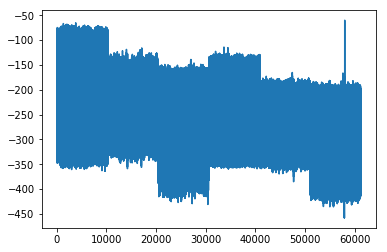

In [22]:
plt.plot(f0)

In [23]:
A = utils_BA.bundle_adjustment_sparsity(
    n_cameras, n_points, camera_indices, point_indices)

In [24]:
import time
from scipy.optimize import least_squares

In [25]:
t0 = time.time()
res = least_squares(utils_BA.fun, x0, jac_sparsity=A, 
                    verbose=2, x_scale='jac', 
                    ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, 
                          camera_indices, 
                          point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3789e+09                                    1.91e+12    
       1              4         2.2968e+09      8.20e+07       1.56e+03       2.69e+10    
       2              6         2.1520e+09      1.45e+08       9.98e+01       2.25e+10    
       3              7         1.9623e+09      1.90e+08       4.00e+02       1.56e+10    
       4              8         1.6343e+09      3.28e+08       6.01e+02       4.34e+09    
       5              9         1.1880e+09      4.46e+08       7.29e+02       5.62e+10    
       6             11         1.0988e+09      8.92e+07       2.16e+02       3.95e+12    
       7             13         1.0692e+09      2.96e+07       6.83e+01       2.60e+12    
       8             15         1.0474e+09      2.18e+07       3.81e+01       1.14e+13    
       9             17         1.0379e+09      9.49e+06       1.41e+01       2.14e+13    

      90             133        3.9453e+06      9.37e+05       2.11e+01       1.34e+13    
      91             134        3.2719e+06      6.73e+05       3.72e+01       4.48e+13    
      92             135        1.8567e+06      1.42e+06       3.73e+01       4.86e+13    
      93             136        1.2925e+06      5.64e+05       3.18e+01       5.50e+12    
      94             137        8.2400e+05      4.68e+05       1.97e+01       2.66e+12    
      95             139        6.4762e+05      1.76e+05       8.68e+00       2.11e+12    
      96             141        6.0213e+05      4.55e+04       4.41e+00       1.27e+11    
      97             143        5.9410e+05      8.03e+03       2.42e+00       2.29e+11    
      98             144        5.8893e+05      5.17e+03       5.19e+00       1.25e+11    
      99             145        5.7331e+05      1.56e+04       4.66e+00       1.59e+11    
      100            147        5.6775e+05      5.57e+03       2.57e+00       1.61e+11    

In [34]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 243 seconds


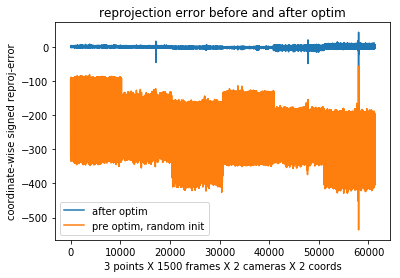

In [35]:
plt.plot(res.fun, label = 'after optim')
plt.plot(f0, label = 'pre optim, random init')
plt.legend()
plt.ylabel('coordinate-wise signed reproj-error')
plt.xlabel('3 points X 1500 frames X 2 cameras X 2 coords')
plt.title('reprojection error before and after optim')
plt.savefig('reproj-err-per-frame-initdlc3d.png')

In [36]:
print(np.where(f0==np.max(f0)))
print(f0[np.where(f0==np.max(f0))])
print(res.fun[np.where(f0==np.max(f0))])

(array([58003]),)
[-56.09681376]
[36.16195028]


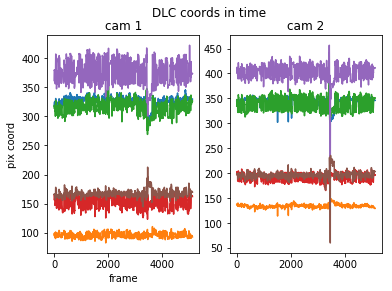

In [37]:
# plt dlc coords in time
plt.subplot(121)
plt.title("cam 1")
plt.xlabel("frame")
plt.ylabel("pix coord")
plt.plot(sliced1[:,[0,1,3,4,6,7]]);
plt.subplot(122)
plt.title("cam 2")
plt.plot(sliced2[:,[0,1,3,4,6,7]]);
plt.suptitle("DLC coords in time");
plt.savefig("dlc_raw_coords_2_cams")

In [38]:
camera_params = res.x[:n_cameras * 9].reshape((n_cameras, 9))
points_3d = res.x[n_cameras * 9:].reshape((n_points, 3))
points_proj = utils_BA.project(points_3d[point_indices], camera_params[camera_indices])

In [39]:
print('cam0 translation')
print(camera_params[0,3:6]) # note that translation is positive in xy
print('cam0 focal distance and two distortions')
print(camera_params[0,6:]) # note that translation is positive in xy
print('cam1 translation')
print(camera_params[1,3:6]) # note that translation is negative in xy
print('cam1 focal distance and two distortions')
print(camera_params[1,6:]) # note that translation is positive in xy

cam0 translation
[-10.94204514   3.87934564   0.37219627]
cam0 focal distance and two distortions
[ 5.69455825e+01 -8.92639996e-02  1.91665651e-04]
cam1 translation
[-0.71989249  3.50092176  0.72107214]
cam1 focal distance and two distortions
[ 7.65993300e-05  4.25671733e-06 -1.49346402e-15]


In [42]:
def plot_reproj_traces(points_2d, points_proj, 
                       frame_range, title, savename):
    '''choose frame range according to num_frames_analyzed and
    num_body_parts and num_cameras. above, we take each body part coord, and stack
    it for all body parts and cameras.'''
    plt.suptitle(title, fontsize=14)
    plt.subplot(211)
    plt.ylabel('x coord')
    plt.plot(points_2d[frame_range,0], 
             color = "gray", linewidth=3);
    plt.plot(points_proj[frame_range,0], 
             color = "red", linestyle = "dashed", linewidth=1);
    plt.subplot(212)
    plt.ylabel('y coord')
    plt.plot(points_2d[frame_range,1], 
             color = "gray", linewidth=3, label = 'DLC 2D');
    plt.plot(points_proj[frame_range,1], 
             color = "red", linestyle = "dashed", linewidth=1, 
             label='re-projection');
    plt.xlabel('frame num.')
    plt.legend(loc = 'lower right')
    plt.savefig(savename + '.png')

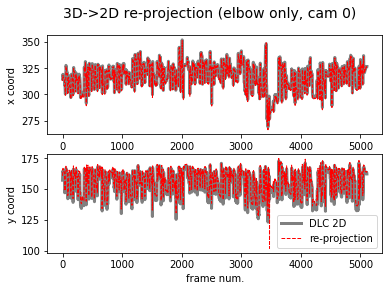

In [43]:
plot_reproj_traces(points_2d, points_proj, 
                       np.arange(num_frames_analyzed,2*num_frames_analyzed), 
                       '3D->2D re-projection (elbow only, cam 0)', 
                   'reproj_elbow_cam0')

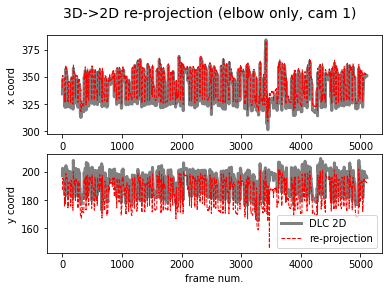

In [44]:
plot_reproj_traces(points_2d, points_proj, 
                       np.arange(
                           4*num_frames_analyzed, 
                           5*num_frames_analyzed), 
                       '3D->2D re-projection (elbow only, cam 1)', 
                   'reproj_elbow_cam1')

In [243]:
print(points_2d.shape)
points_2d_cam1 = points_2d[0:int(points_2d.shape[0]/2),:]
# compute sliced re-proj
#sliced_reverted_1 = 

(30660, 2)


In [244]:
print(res.x.shape) # shape just like x0. first 18 params are camera params. rest are 3d points.
print(x0.shape) # below i show that you could reshape and get your desired values.

(46008,)
(46008,)


In [245]:
print(camera_params.ravel().shape)

(18,)


In [246]:
orig_shape = points_3d.shape
print(orig_shape)
(points_3d.ravel().reshape(orig_shape) == points_3d).all()

(15330, 3)


True

In [48]:
min_y = np.min(points_3d.ravel()) -1
max_y = np.max(points_3d.ravel()) +1

In [50]:
# plt.figure(figsize=(8,8))
# plt.suptitle('3D coords: comparing DLC 3D to BA', fontsize=16)
# plt.subplot(331)
# plt.title('shoulder')
# plt.plot(points_3d[:1500,0], label = 'BA inferred')
# plt.plot(pts_array_3d[:1500,0], label = 'DLC 3d')
# plt.ylabel('x coord')
# plt.legend()
# #plt.ylim(min_y, max_y)
# plt.subplot(332)
# plt.plot(points_3d[1500:3000,0])
# plt.plot(pts_array_3d[1500:3000,0])
# plt.title('elbow')
# #plt.ylim(min_y, max_y)
# plt.subplot(333)
# plt.plot(points_3d[3000:4500,0])
# plt.plot(pts_array_3d[3000:4500,0])
# plt.title('end-effector')
# #plt.ylim(min_y, max_y)
# plt.subplot(334)
# plt.plot(points_3d[:1500,1])
# plt.plot(pts_array_3d[:1500,1])
# plt.ylabel('y coord')
# #plt.ylim(min_y, max_y)
# plt.subplot(335)
# plt.plot(points_3d[1500:3000,1])
# plt.plot(pts_array_3d[1500:3000,1])
# #plt.ylim(min_y, max_y)
# plt.subplot(336)
# plt.plot(points_3d[3000:4500,1])
# plt.plot(pts_array_3d[3000:4500,1])
# #plt.ylim(min_y, max_y)
# plt.subplot(337)
# plt.plot(points_3d[:1500,2])
# plt.plot(pts_array_3d[:1500,2])
# #plt.ylim(min_y, max_y)
# plt.ylabel('z coord')
# plt.subplot(338)
# plt.plot(points_3d[1500:3000,2])
# plt.plot(pts_array_3d[1500:3000,2])
# #plt.ylim(min_y, max_y)
# plt.subplot(339)
# plt.plot(points_3d[3000:4500,2])
# plt.plot(pts_array_3d[3000:4500,2])
# #plt.ylim(min_y, max_y)
# plt.savefig('3d_recovered_coords.png')

In [248]:
def revert_ordered_arr_to_dict(body_parts, ordered_arr):
    n_frames = int(ordered_arr.shape[0]/body_parts)
    coord_dict = {}
    coord_dict["x_coords"] = np.zeros((body_parts, n_frames))
    coord_dict["y_coords"] = np.zeros((body_parts, n_frames))
    coord_dict["z_coords"] = np.zeros((body_parts, n_frames))
    for f_ind in range(body_parts):
        coord_dict["x_coords"][f_ind, :] = ordered_arr[f_ind*n_frames:\
                                                       (f_ind+1)*n_frames, 0]
        coord_dict["y_coords"][f_ind, :] = ordered_arr[f_ind*n_frames:\
                                                       (f_ind+1)*n_frames, 1]
        coord_dict["z_coords"][f_ind, :] = ordered_arr[f_ind*n_frames:\
                                                       (f_ind+1)*n_frames, 2]
    return coord_dict

In [53]:
BA_3d_recovered_dict = utils_IO.revert_ordered_arr_to_dict(3, points_3d)
DLC_3d_dict = utils_IO.revert_ordered_arr_to_dict(3, pts_array_3d)

AttributeError: module 'utils_IO' has no attribute 'revert_ordered_arr_to_dict'

In [256]:
DLC_3d_dict["x_coords"].shape

(3, 5110)

In [257]:
# check that our dicts make sense.
DLC_3d_dict_check = {}
DLC_3d_dict_check["x_coords"] = sliced3d[:,[0,3,6]]
(DLC_3d_dict_check["x_coords"] == DLC_3d_dict["x_coords"].T).all()

True

In [258]:
def revert_ordered_arr_2d_to_dict(body_parts, n_cams, ordered_arr):
    '''remove from here. in IO'''
    n_frames = int(ordered_arr.shape[0]/(body_parts*n_cams))
    coord_list_of_dicts = []
    
    for cam in range(n_cams):
        coord_dict = {}
        coord_dict["x_coords"] = np.zeros((body_parts, n_frames))
        coord_dict["y_coords"] = np.zeros((body_parts, n_frames))
                   
        curr_cam_arr = ordered_arr[cam*n_frames*body_parts:\
                                   (cam+1)*n_frames*body_parts]
#         print(cam*n_frames*body_parts)
#         print( (cam+1)*n_frames*body_parts)

        for f_ind in range(body_parts):
            coord_dict["x_coords"][f_ind, :] = curr_cam_arr[f_ind*n_frames:\
                                                           (f_ind+1)*n_frames, 0]
            coord_dict["y_coords"][f_ind, :] = curr_cam_arr[f_ind*n_frames:\
                                                           (f_ind+1)*n_frames, 1]
        coord_list_of_dicts.append(coord_dict)
    return coord_list_of_dicts

In [259]:
coord_list_of_dicts = revert_ordered_arr_2d_to_dict(3, 2, points_2d)

In [260]:
# check
print(len(coord_list_of_dicts))
print(coord_list_of_dicts[-1]["x_coords"].shape)
(coord_list_of_dicts[-1]["x_coords"].T == sliced2[:,[0,3,6]]).all()

2
(3, 5110)


True

In [261]:
os.getcwd()
image_folder = '/Users/danbiderman/Dropbox/Columbia/1.Dan/John'

In [443]:
# VALIDATE THESE NUMBERS!
video_start_index = 900 # where would you like to start making the video.
first_image_index = 4500 # index that we used above to chop the arrays
n_frames = 200

In [444]:
import matplotlib.image as mpimg
# NOTE the numbers you input.
start_index = first_image_index + video_start_index # should match the number we used above for BA
max_images = n_frames
img_1_shape = np.shape(mpimg.imread(image_folder + 
                                    '/cam_1_09_15_all_images/camera-1-%04d.jpg'% 
                                    (start_index+1)))
img_2_shape = np.shape(mpimg.imread(image_folder + 
                                    '/cam_2_09_15_all_images/camera-2-%04d.jpg'% 
                                (start_index+1)))
print('image dims')
print(img_1_shape)
print(img_2_shape)

# save room: create image arrays
img_1_array = np.zeros((img_1_shape[0], img_1_shape[1], max_images))
img_2_array = np.zeros((img_2_shape[0], img_2_shape[1], max_images))

# now fill those arrays with images
for i in range(0,max_images):
    # note the numbering scheme below!!!
    img_1_array[:,:,i] = mpimg.imread(image_folder + '/cam_1_09_15_all_images/camera-1-%04d.jpg'% 
               (start_index+i+1))[:,:,0]
    img_2_array[:,:,i]  = mpimg.imread(image_folder + '/cam_2_09_15_all_images/camera-2-%04d.jpg'% 
               (start_index+i+1))[:,:,0]
print('images loaded')

# crop desired pixels
n_row_pix = 300
n_col_pix = 300
row_min_img1, col_min_img1 = 0, 200
row_min_img2, col_min_img2 = 50, 220

# create cropped arrays
img_1_cropped_array = img_1_array[row_min_img1:row_min_img1+ n_row_pix,
                                  col_min_img1:col_min_img1 + n_col_pix,:]
img_2_cropped_array = img_2_array[row_min_img2:row_min_img2+ n_row_pix,
                                  col_min_img2:col_min_img2 + n_col_pix,:]

print('created cropped arrays.')
print('array 1 shape: %s, array 2 shape: %s' 
      % (str(np.shape(img_1_cropped_array)),  str(np.shape(img_2_cropped_array))))

# stack these horizontally next to eachother for plotting
stacked = np.hstack([img_1_cropped_array,img_2_cropped_array]) 
print('hstacked array shape %s' % str(stacked.shape))

image dims
(512, 640, 3)
(512, 640, 3)
images loaded
created cropped arrays.
array 1 shape: (300, 300, 200), array 2 shape: (300, 300, 200)
hstacked array shape (300, 600, 200)


In [394]:
'''In: time indices; DLC tracked pts in 2D (cam1+cam2); DLC 3D tracked pts; recovered dict
we loop over time points, and present the images along with our 3D plot
figure should be presented using '''
# this function assumes that we're plotting the first n frames of our dictionaries
def video_recover_plots(noisy_pose_dict, recovered_pose_dict, \
                        stacked_images, DLC_sliced1, DLC_sliced2, reproj_list_of_dicts,\
                            save_name, title, n_frames, lim_abs): 
    '''seems to work.this version has the gridspec including 
    what i learned - using p3.Axes3D along with regular ax.plot was helpful.
    in ax.plot I just use x,y,z, coordinates.
    there is no init function like in the 2d plots, we initialize the lines
    with the vales at the zeroth timepoint '''
    from matplotlib.animation import FuncAnimation
    import mpl_toolkits.mplot3d.axes3d as p3
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(constrained_layout=True, figsize = (11,6))

    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[:2, 0])
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html

    #fig = plt.figure()
    ax2.view_init(elev=-82., azim=-72) # specific for costa data, found manually
    
#    ax.set_xlim3d([-2.0, 2.0])
#    ax.set_xlabel('X')
#
#    ax.set_ylim3d([-2.0, 2.0])
#    ax.set_ylabel('Y')
#
#    ax.set_zlim3d([-2.0, 2.0])
#    ax.set_zlabel('Z')
    
    im_stacked = ax1.imshow(stacked_images[:,:,0], cmap="gray") # all the lines below consider a SPECIFIC CROP
    line_1, = ax1.plot(DLC_sliced1[0+1,[0,3,6]]-200, DLC_sliced1[0+1,[1,4,7]], 
        'r*',markersize=10)
    
    line_1_reproj, = ax1.plot(reproj_list_of_dicts[0]["x_coords"][:, 0+1]-200,
                              reproj_list_of_dicts[0]["y_coords"][:, 0+1],
    'b+',markersize=10)
#    scatt_1 = ax1.scatter(DLC_sliced1[0+1,[0,3,6]]-200, DLC_sliced1[0+1,[1,4,7]], 
#        color='red', marker='*', s=50)
    line_2, = ax1.plot(DLC_sliced2[0+1,[0,3,6]]-220+300, DLC_sliced2[0+1,[1,4,7]]-50, # +300 due to stack
            'r*',markersize=10)
    line_2_reproj, = ax1.plot(reproj_list_of_dicts[1]["x_coords"][:, 0+1]-220+300,
                              reproj_list_of_dicts[1]["y_coords"][:, 0+1]-50,
    'b+',markersize=10)
    
    line_v = ax1.axvline(x=300, ymin = 0, ymax = 300, color = 'white', linewidth=5)
    ax1.set_title('View 1             View 2', fontsize = 16, weight = "bold")
    ax1.axis('off')
    ax1.legend(loc = "lower left", labels = ['DLC 2D', 'BA-reproj'])
    
    # init lines with true data, no init method.
    line_noise, = ax2.plot(noisy_pose_dict["x_coords"][:,0], \
                           noisy_pose_dict["y_coords"][:,0], \
                           noisy_pose_dict["z_coords"][:,0],'ro-', lw = 4, \
                           markersize=5, label = "DLC 3D")
    line_recovered, = ax2.plot(recovered_pose_dict["x_coords"][:,0], \
                           recovered_pose_dict["y_coords"][:,0], \
                           recovered_pose_dict["z_coords"][:,0], 'ko-', lw=4, \
                               markersize =5, 
                           label = "BA_3D",alpha=0.5)
#    plt.legend(loc = "lower left")
#    plt.title(title, fontsize = 16)
    
    # dan 2/28 can be avoided 
    # new for costa data
#     ax2.set_xlim3d([-2.0, 2.0])
#     #ax.set_xticks([])
#     ax2.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
#     ax2.set_xticklabels([])
#     ax2.tick_params('x')
#     ax2.set_xlabel('X', fontsize=12, labelpad = 0.1)
#     ax2.set_ylim3d([-2.0, 2.0])
#     ax2.set_yticks([-2.0, -1.0, 0.0, 1.0, 2.0])
#     ax2.set_yticklabels([])
#     ax2.set_ylabel('Y', fontsize=12)
#     ax2.set_zlim3d([-2.0, 2.0])
#     ax2.set_zticks([-2.0, -1.0, 0.0, 1.0, 2.0])
#     ax2.set_zticklabels([])
#     ax2.set_zlabel('Z', fontsize=12)
    ax2.legend(loc = "lower left", fontsize=10)
    ax2.set_title('DLC Calib VS BA', fontsize = 16, weight = "bold", pad=18)
   
    # need to get images here
    def animate(i, stacked_images, im_stacked,
                DLC_sliced1, line_1, DLC_sliced2, line_2, 
                reproj_list, line_1_reproj, line_2_reproj,
                line_v,
                noisy_pose_dict, line_noise,
                recovered_pose_dict, line_recovered): # note, the loop has to see all these datasets
       
        im_stacked.set_data(stacked_images[:,:,i]) # all the lines below consider a SPECIFIC CROP
        line_1.set_data(DLC_sliced1[i+1,[0,3,6]]-200, DLC_sliced1[i+1,[1,4,7]])
        line_1_reproj.set_data(reproj_list_of_dicts[0]["x_coords"][:, i+1]-200,
                              reproj_list_of_dicts[0]["y_coords"][:, i+1])
        line_2.set_data(DLC_sliced2[i+1,[0,3,6]]-220+300, DLC_sliced2[i+1,[1,4,7]]-50)
        line_2_reproj.set_data(reproj_list_of_dicts[1]["x_coords"][:, i+1]-220+300,
                              reproj_list_of_dicts[1]["y_coords"][:, i+1]-50)
        line_v= ax1.axvline(x=300, ymin = 0, ymax = 300, color = 'white', linewidth=5) #.set_data(x=300, ymin = 0, ymax = 300)
        # noisy obs
        line_noise.set_data(noisy_pose_dict["x_coords"][:,i], \
                           noisy_pose_dict["y_coords"][:,i])
        line_noise.set_3d_properties(noisy_pose_dict["z_coords"][:,i])
        
        # recovered
        line_recovered.set_data(recovered_pose_dict["x_coords"][:,i], \
                           recovered_pose_dict["y_coords"][:,i])
        line_recovered.set_3d_properties(recovered_pose_dict["z_coords"][:,i])
         
        return im_stacked, line_1, line_2, line_1_reproj, line_2_reproj, line_v, line_noise, line_recovered# not sure the return is needed. check.

    anim = FuncAnimation(fig, animate, fargs=(stacked_images, im_stacked, 
                                              DLC_sliced1, line_1, 
                                              DLC_sliced2, line_2, reproj_list_of_dicts,
                                              line_1_reproj, line_2_reproj, line_v, \
                                              noisy_pose_dict, line_noise,
                                               recovered_pose_dict, line_recovered), #all inputs to loop
                                   frames=n_frames, interval=50, blit= False)# blit false important?

    #anim.save("recover.mp4")
    #anim.save(save_name + '.gif', writer='Imagekick') # works
    anim.save(save_name + ".gif", writer = "pillow") # pillow important

In [445]:
coord_list_of_dicts = revert_ordered_arr_2d_to_dict(3, 2, points_proj)
BA_3d_recovered_dict = revert_ordered_arr_to_dict(3, points_3d)
DLC_3d_dict = revert_ordered_arr_to_dict(3, pts_array_3d)

In [446]:
coord_list_of_dicts_chopped = []
for i in range(len(coord_list_of_dicts)):
    # note we're padding with an extra frame, for plotting
    chopped_temp = chop_dict(
        coord_list_of_dicts[i], False, video_start_index, n_frames+1)
    coord_list_of_dicts_chopped.append(chopped_temp)
# test
print((coord_list_of_dicts_chopped[0]['x_coords'] == \
coord_list_of_dicts[0]['x_coords'][:, 
video_start_index:(video_start_index+n_frames+1)]).all())

True


In [447]:
# note we're padding with an extra frame, for plotting
BA_3d_recovered_dict_chopped = chop_dict(BA_3d_recovered_dict, 
                                         True, video_start_index, 
                                         n_frames+1)
DLC_3d_dict_chopped = chop_dict(DLC_3d_dict, 
                                         True, video_start_index, 
                                         n_frames+1)

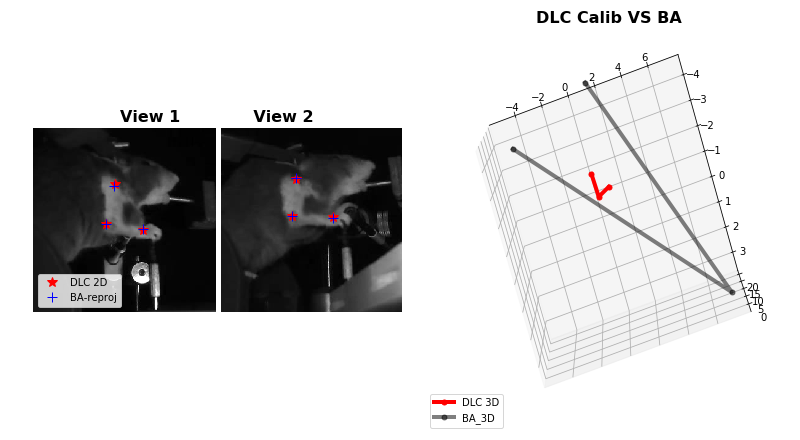

In [448]:
# note we're padding with an extra frame, for plotting
video_recover_plots(DLC_3d_dict_chopped, 
                    BA_3d_recovered_dict_chopped, 
                    stacked, 
                    sliced1[
                        video_start_index:video_start_index+n_frames+1,:], 
                    sliced2[
                        video_start_index:video_start_index+n_frames+1,:],                     
                    coord_list_of_dicts_chopped,
                    'video_test_BA_reproj', 'test', n_frames, 5)

In [449]:
# # older, worked
# video_recover_plots(DLC_3d_dict, 
#                     BA_3d_recovered_dict, 
#                     stacked, 
#                     sliced1, 
#                     sliced2, 
#                     coord_list_of_dicts,
#                     'video_test_BA_reproj', 'test', n_frames, 5)

## CCA
### test if DLC 3D linearly transforms to the BA

In [289]:
from sklearn.cross_decomposition import CCA

In [290]:
print(points_3d.shape)
print(pts_array_3d.shape)

(15330, 3)
(15330, 3)


In [416]:
def chop_dict(dict_to_chop, is3d, start_frame, n_frames):
    
    if is3d:
        key_names = ['x_coords', 'y_coords', 'z_coords']
    else:
        key_names = ['x_coords', 'y_coords']
        
    temp_dict = {}
    for i in range(len(key_names)):
        temp_dict[key_names[i]] = dict_to_chop[key_names[i]][
        :,start_frame:(start_frame+n_frames)]
    
    return temp_dict

In [424]:
# test 3d
dict_test = chop_dict(DLC_3d_dict, True, 700, 100)
print((dict_test["z_coords"] == \
       DLC_3d_dict["z_coords"][:,700:800]).all())
# test 2d
dict_test = chop_dict(coord_list_of_dicts[i], False, 700, 100)
print((dict_test["y_coords"] == \
       coord_list_of_dicts[i]["y_coords"][:,700:800]).all())

True
True


In [404]:
coord_list_of_dicts_chopped = []
for i in range(len(coord_list_of_dicts)):
    coord_list_of_dicts_chopped[i] = chop_dict(
        coord_list_of_dicts[i], start_frame, n_frames)

NameError: name 'start_frame' is not defined

In [391]:
# test
DLC_3d_dict["x_coords"].shape
dict_test = chop_dict(DLC_3d_dict, 700, 100)
(dict_test["x_coords"] == DLC_3d_dict["x_coords"][:,700:800]).all()

True

In [349]:
def dict_to_arr(dict_3d):
    'convert dicts (in the form above) to arrays. '
    array_temp = np.hstack([dict_3d['x_coords'].T, 
          dict_3d['y_coords'].T,
          dict_3d['z_coords'].T])
    return  array_temp[:, [0,3,6, 1,4,7, 2, 5, 8]]

In [350]:
(dict_to_arr(DLC_3d_dict) == sliced3d).all()

True

In [351]:
array9d_BA = dict_to_arr(BA_3d_recovered_dict)
array9d_DLC = dict_to_arr(DLC_3d_dict)

In [376]:
cca = CCA(n_components=3)
cca.fit(array9d_DLC, array9d_BA)

CCA(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [377]:
cca.score(array9d_DLC, array9d_BA, sample_weight=None)

-2577.0222777339823

In [378]:
predicted = cca.predict(array9d_DLC)

In [355]:
print(predicted[2,:])
print(array9d_ba[2,:])

[  55.25488052   46.83424253 -155.27049226   22.37487084   15.85297743
  -44.36476607  103.56437054  107.24508063 -366.27022665]
[-2.50463696  8.03262173  1.60059481 -2.57062826  3.02444176 -4.99999955
 14.0821267  -3.05692332 25.58152605]


In [356]:
predicted.shape

(5110, 9)

In [375]:
def arr3d_to_dict(arr):
    'convert n_frames by 9 array to a dict with x,y,z coords'
    dict_3d = {}
    dict_3d["x_coords"] = arr[:,[0, 3, 6]].T
    dict_3d["y_coords"] = arr[:,[1, 4, 7]].T
    dict_3d["z_coords"] = arr[:,[2, 5, 8]].T
    return dict_3d

# check
check3d = arr3d_to_dict(sliced3d)
(check3d["x_coords"] == DLC_3d_dict["x_coords"]).all()

True

In [451]:
'''In: time indices; DLC tracked pts in 2D (cam1+cam2); DLC 3D tracked pts; recovered dict
we loop over time points, and present the images along with our 3D plot
figure should be presented using '''
# this function assumes that we're plotting the first n frames of our dictionaries
def video_recover_plots_CCA(noisy_pose_dict, recovered_pose_dict, \
                        CCA_pose_dict, stacked_images, DLC_sliced1, DLC_sliced2, reproj_list_of_dicts,\
                            save_name, title, n_frames, lim_abs): 
    '''seems to work.this version has the gridspec including 
    what i learned - using p3.Axes3D along with regular ax.plot was helpful.
    in ax.plot I just use x,y,z, coordinates.
    there is no init function like in the 2d plots, we initialize the lines
    with the vales at the zeroth timepoint '''
    from matplotlib.animation import FuncAnimation
    import mpl_toolkits.mplot3d.axes3d as p3
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(constrained_layout=True, figsize = (11,6))

    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[:2, 0])
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html

    #fig = plt.figure()
    ax2.view_init(elev=-82., azim=-72) # specific for costa data, found manually
    
#    ax.set_xlim3d([-2.0, 2.0])
#    ax.set_xlabel('X')
#
#    ax.set_ylim3d([-2.0, 2.0])
#    ax.set_ylabel('Y')
#
#    ax.set_zlim3d([-2.0, 2.0])
#    ax.set_zlabel('Z')
    
    im_stacked = ax1.imshow(stacked_images[:,:,0], cmap="gray") # all the lines below consider a SPECIFIC CROP
    line_1, = ax1.plot(DLC_sliced1[0+1,[0,3,6]]-200, DLC_sliced1[0+1,[1,4,7]], 
        'r*',markersize=10)
    
    line_1_reproj, = ax1.plot(reproj_list_of_dicts[0]["x_coords"][:, 0+1]-200,
                              reproj_list_of_dicts[0]["y_coords"][:, 0+1],
    'b+',markersize=10)
#    scatt_1 = ax1.scatter(DLC_sliced1[0+1,[0,3,6]]-200, DLC_sliced1[0+1,[1,4,7]], 
#        color='red', marker='*', s=50)
    line_2, = ax1.plot(DLC_sliced2[0+1,[0,3,6]]-220+300, DLC_sliced2[0+1,[1,4,7]]-50, # +300 due to stack
            'r*',markersize=10)
    line_2_reproj, = ax1.plot(reproj_list_of_dicts[1]["x_coords"][:, 0+1]-220+300,
                              reproj_list_of_dicts[1]["y_coords"][:, 0+1]-50,
    'b+',markersize=10)
    
    line_v = ax1.axvline(x=300, ymin = 0, ymax = 300, color = 'white', linewidth=5)
    ax1.set_title('View 1             View 2', fontsize = 16, weight = "bold")
    ax1.axis('off')
    ax1.legend(loc = "lower left", labels = ['DLC 2D', 'BA-reproj'])
    
    # init lines with true data, no init method.
    line_noise, = ax2.plot(noisy_pose_dict["x_coords"][:,0], \
                           noisy_pose_dict["y_coords"][:,0], \
                           noisy_pose_dict["z_coords"][:,0],'ro-', lw = 4, \
                           markersize=5, label = "DLC 3D")
    line_recovered, = ax2.plot(recovered_pose_dict["x_coords"][:,0], \
                           recovered_pose_dict["y_coords"][:,0], \
                           recovered_pose_dict["z_coords"][:,0], 'ko-', lw=4, \
                               markersize =5, 
                           label = "BA_3D",alpha=0.5)
    line_CCA, = ax2.plot(CCA_pose_dict["x_coords"][:,0], \
                           CCA_pose_dict["y_coords"][:,0], \
                           CCA_pose_dict["z_coords"][:,0], 'bo-', lw=4, \
                               markersize =5, 
                           label = "CCA pred for BA",alpha=0.5)
#    plt.legend(loc = "lower left")
#    plt.title(title, fontsize = 16)
    
    # dan 2/28 can be avoided 
    # new for costa data
#     ax2.set_xlim3d([-2.0, 2.0])
#     #ax.set_xticks([])
#     ax2.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
#     ax2.set_xticklabels([])
#     ax2.tick_params('x')
#     ax2.set_xlabel('X', fontsize=12, labelpad = 0.1)
#     ax2.set_ylim3d([-2.0, 2.0])
#     ax2.set_yticks([-2.0, -1.0, 0.0, 1.0, 2.0])
#     ax2.set_yticklabels([])
#     ax2.set_ylabel('Y', fontsize=12)
#     ax2.set_zlim3d([-2.0, 2.0])
#     ax2.set_zticks([-2.0, -1.0, 0.0, 1.0, 2.0])
#     ax2.set_zticklabels([])
#     ax2.set_zlabel('Z', fontsize=12)
    ax2.legend(loc = "lower left", fontsize=10)
    ax2.set_title('DLC Calib VS BA', fontsize = 16, weight = "bold", pad=18)
   
    # need to get images here
    def animate(i, stacked_images, im_stacked,
                DLC_sliced1, line_1, DLC_sliced2, line_2, 
                reproj_list, line_1_reproj, line_2_reproj,
                line_v,
                noisy_pose_dict, line_noise,
                recovered_pose_dict, line_recovered,
               CCA_pose_dict, line_CCA): # note, the loop has to see all these datasets
       
        im_stacked.set_data(stacked_images[:,:,i]) # all the lines below consider a SPECIFIC CROP
        line_1.set_data(DLC_sliced1[i+1,[0,3,6]]-200, DLC_sliced1[i+1,[1,4,7]])
        line_1_reproj.set_data(reproj_list_of_dicts[0]["x_coords"][:, i+1]-200,
                              reproj_list_of_dicts[0]["y_coords"][:, i+1])
        line_2.set_data(DLC_sliced2[i+1,[0,3,6]]-220+300, DLC_sliced2[i+1,[1,4,7]]-50)
        line_2_reproj.set_data(reproj_list_of_dicts[1]["x_coords"][:, i+1]-220+300,
                              reproj_list_of_dicts[1]["y_coords"][:, i+1]-50)
        line_v= ax1.axvline(x=300, ymin = 0, ymax = 300, color = 'white', linewidth=5) #.set_data(x=300, ymin = 0, ymax = 300)
        # noisy obs
        line_noise.set_data(noisy_pose_dict["x_coords"][:,i], \
                           noisy_pose_dict["y_coords"][:,i])
        line_noise.set_3d_properties(noisy_pose_dict["z_coords"][:,i])
        
        # recovered
        line_recovered.set_data(recovered_pose_dict["x_coords"][:,i], \
                           recovered_pose_dict["y_coords"][:,i])
        line_recovered.set_3d_properties(recovered_pose_dict["z_coords"][:,i])
        
        # recovered
        line_CCA.set_data(CCA_pose_dict["x_coords"][:,i], \
                           CCA_pose_dict["y_coords"][:,i])
        line_CCA.set_3d_properties(CCA_pose_dict["z_coords"][:,i])
         
         
        return im_stacked, line_1, line_2, line_1_reproj, line_2_reproj, line_v, line_noise, line_recovered, line_CCA# not sure the return is needed. check.

    anim = FuncAnimation(fig, animate, fargs=(stacked_images, im_stacked, 
                                              DLC_sliced1, line_1, 
                                              DLC_sliced2, line_2, reproj_list_of_dicts,
                                              line_1_reproj, line_2_reproj, line_v, \
                                              noisy_pose_dict, line_noise,
                                               recovered_pose_dict, line_recovered,
                                             CCA_pose_dict, line_CCA), #all inputs to loop
                                   frames=n_frames, interval=50, blit= False)# blit false important?

    #anim.save("recover.mp4")
    #anim.save(save_name + '.gif', writer='Imagekick') # works
    anim.save(save_name + ".gif", writer = "pillow") # pillow important

In [455]:
CCA_pred_dict = arr3d_to_dict(predicted)
CCA_pred_dict_chopped = chop_dict(CCA_pred_dict, True, 
                                  video_start_index, n_frames+1)

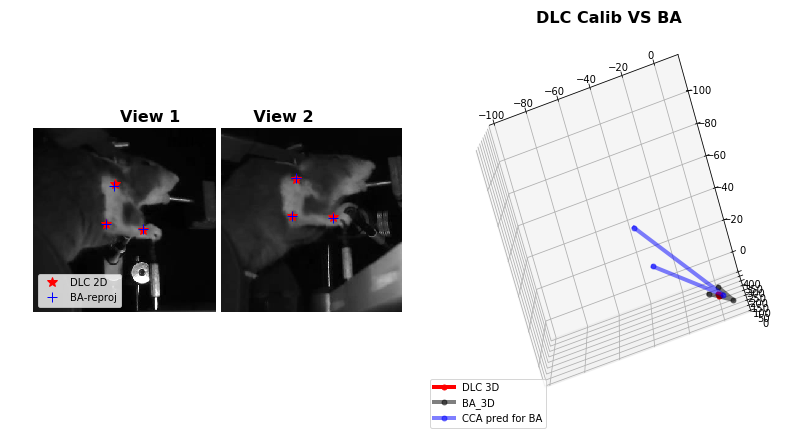

In [456]:
video_recover_plots_CCA(DLC_3d_dict_chopped, 
                    BA_3d_recovered_dict_chopped,
                    CCA_pred_dict_chopped,
                    stacked, 
                    sliced1[
                        video_start_index:video_start_index+n_frames+1,:], 
                    sliced2[
                        video_start_index:video_start_index+n_frames+1,:],                     
                    coord_list_of_dicts_chopped,
                    'video_test_BA_reproj', 'test', n_frames, 5)